In [1]:
! pip install beautifulsoup4
! pip install tqdm
! pip install pandas Pyarrow 
! pip install tensorflow tensorflow_hub tensorflow_text

### scrape all the news form the post homepage

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from typing import List, Dict, Optional
import time
from tqdm import tqdm

df = None  # Global variable to store the DataFrame

def scrape_news(url: str) -> List[Dict[str, Optional[str]]]:
    """
    Scrape news data from a given website.

    Parameters:
    url (str): The URL of the website to scrape.

    Returns:
    List[Dict[str, Optional[str]]]: A list of dictionaries containing the scraped news data.
    """
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")
    news_inner_list = soup.find_all(class_="news__inner")
    news_data = []

    for news_inner in news_inner_list:
        title_element = news_inner.find(class_="news__title")
        title = title_element.text.strip() if title_element else None

        date_element = news_inner.find(class_="news__date-day")
        date = date_element.text.strip() if date_element else None

        author_element = news_inner.find(class_="news__author")
        author = author_element.text.strip() if author_element else None

        link_element = news_inner.find(class_="news__title").find('a')
        link = link_element['href'] if link_element else None

        news_data.append({'title': title, 'date': date, 'author': author, 'link': link})

    return news_data

def parse_article(link: str) -> Optional[Dict[str, Optional[str]]]:
    """
    Parse an article from a given link.

    Parameters:
    link (str): The URL of the article to parse.

    Returns:
    Optional[Dict[str, Optional[str]]]: A dictionary containing the parsed article data, or None if the request was unsuccessful.
    """
    response = requests.get(link)
    if response.status_code != 200:
        return None

    soup = BeautifulSoup(response.content, "html.parser")
    title_element = soup.find(class_="news__title")
    title = title_element.text.strip() if title_element else None

    date_element = soup.find(class_="news__date-day")
    date = date_element.text.strip() if date_element else None

    author_element = soup.find(class_="news__author")
    author = author_element.text.strip() if author_element else None

    content_element = soup.find(class_="news__content")
    content = content_element.text.strip() if content_element else None

    a_tag = soup.find('a', rel='category tag')
    tag = a_tag.text if a_tag else None

    article_data = {
        'title': title,
        'date': date,
        'author': author,
        'content': content,
        'tag': tag
    }

    return article_data


In [3]:
df = None
url = "https://web.archive.org/web/20240101002406/https://www.open.online/"
news_data = scrape_news(url)
parsed_articles = []

try:
    for news in tqdm(news_data, desc="Parsing articles"):
        article_data = parse_article(news['link'])
        if article_data:
            article_data['site'] = 'www.open.online'
            parsed_articles.append(article_data)
        time.sleep(3) 
        # TODO: implement an exponential backoff strategy to handle failed requests
except Exception as e:
    print(f"An exception occurred: {str(e)}")
    df = pd.DataFrame(parsed_articles)

if df is None:
    df = pd.DataFrame(parsed_articles)

print(df)

Parsing articles:  39%|███▉      | 19/49 [01:38<02:35,  5.19s/it]

An exception occurred: HTTPSConnectionPool(host='web.archive.org', port=443): Max retries exceeded with url: /web/20240101002406/https://www.open.online/2023/12/31/concerti-capodanno-2024-citta-italiane/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fbe0ea8cfa0>: Failed to establish a new connection: [Errno 111] Connection refused'))
                                                title              date  \
0   Mattarella su Ucraina e Gaza: «La pace va cost...  31 Dicembre 2023   
1   Capodanno, in Nuova Zelanda è già arrivato il ...  31 Dicembre 2023   
2   Sorbillo e la pizza all’ananas che non piace a...  31 Dicembre 2023   
3   Capodanno, Feltri all’Aria che Tira: «Non me n...  30 Dicembre 2023   
4   Manuel Agnelli, con spolverino, grembiule e pe...  31 Dicembre 2023   
5   Mulè chiamato «signora presidente» dalla dem G...  31 Dicembre 2023   
6   Ultima Generazione imbratta l’albero di Gucci ...  29 Dicembre 2023   
7   Chi è la coppia della prop

In [4]:
df_news = pd.DataFrame(parsed_articles)
df_news

,title,date,author,content,tag,site
0,Mattarella su Ucraina e Gaza: «La pace va cost...,31 Dicembre 2023,di Redazione,"Guerra, violenza sulle donne, lavoro. Sono que...",POLITICA,www.open.online
1,"Capodanno, in Nuova Zelanda è già arrivato il ...",31 Dicembre 2023,di Redazione,L’Oceania è il primo Continente a festeggiare ...,MONDO,www.open.online
2,Sorbillo e la pizza all’ananas che non piace a...,31 Dicembre 2023,di Redazione,Pochi argomenti riescono a scaldare gli animi ...,CULTURA & SPETTACOLO,www.open.online
3,"Capodanno, Feltri all’Aria che Tira: «Non me n...",30 Dicembre 2023,di Redazione,A Vittorio Feltri non piacciono le festività. ...,ATTUALITÀ,www.open.online
4,"Manuel Agnelli, con spolverino, grembiule e pe...",31 Dicembre 2023,di Redazione,Con solo un grembiule addosso spolvera una spe...,CULTURA & SPETTACOLO,www.open.online
5,Mulè chiamato «signora presidente» dalla dem G...,31 Dicembre 2023,di Redazione,"Il vicepresidente della Camera, Giorgio Mulé, ...",POLITICA,www.open.online
6,Ultima Generazione imbratta l’albero di Gucci ...,29 Dicembre 2023,di Redazione,Gli attivisti per il clima di Ultima Generazio...,ATTUALITÀ,www.open.online
7,Chi è la coppia della proposta di matrimonio f...,30 Dicembre 2023,di Stefania Carboni,«Che c… fai? Non ero pronta». Quella frase la ...,ATTUALITÀ,www.open.online
8,"Ex Gkn, scongiurati i licenziamenti. Il messag...",28 Dicembre 2023,di Redazione,I 185 operai della ex-Gkn di Campi Bisenzio (F...,ATTUALITÀ,www.open.online
9,"Altra racchetta, stesso stile. Jannik Sinner e...",30 Dicembre 2023,di Redazione,«Quanto mi mancava». Reduce dallo storico succ...,SPORT,www.open.online


In [5]:
df_day = df_news[df_news['date'] == '31 Dicembre 2023']
df_day

,title,date,author,content,tag,site
0,Mattarella su Ucraina e Gaza: «La pace va cost...,31 Dicembre 2023,di Redazione,"Guerra, violenza sulle donne, lavoro. Sono que...",POLITICA,www.open.online
1,"Capodanno, in Nuova Zelanda è già arrivato il ...",31 Dicembre 2023,di Redazione,L’Oceania è il primo Continente a festeggiare ...,MONDO,www.open.online
2,Sorbillo e la pizza all’ananas che non piace a...,31 Dicembre 2023,di Redazione,Pochi argomenti riescono a scaldare gli animi ...,CULTURA & SPETTACOLO,www.open.online
4,"Manuel Agnelli, con spolverino, grembiule e pe...",31 Dicembre 2023,di Redazione,Con solo un grembiule addosso spolvera una spe...,CULTURA & SPETTACOLO,www.open.online
5,Mulè chiamato «signora presidente» dalla dem G...,31 Dicembre 2023,di Redazione,"Il vicepresidente della Camera, Giorgio Mulé, ...",POLITICA,www.open.online
11,I pacchi in ritardo dei prodotti di Chiara Fer...,31 Dicembre 2023,di Redazione,Tutta colpa del «picco di vendite se i prodott...,ATTUALITÀ,www.open.online
12,"Chiara Ferragni riappare sui social, il finto ...",31 Dicembre 2023,di Redazione,"A poche ore dal Capodanno 2024, Chiara Ferragn...",CULTURA & SPETTACOLO,www.open.online
13,"Bimbo di 11 colpito a un occhio da un petardo,...",31 Dicembre 2023,di Redazione,Un bambino di 11 anni ha perso l’uso di un occ...,ATTUALITÀ,www.open.online
15,"«Quando sorridi sei la più bella…», il coro de...",31 Dicembre 2023,di Redazione,I tifosi dell’Inter tornano a dedicare un coro...,SPORT,www.open.online
17,"Segre-Seymandi, l’imprenditrice sui possibili ...",31 Dicembre 2023,di Redazione,Sarà difficile da dimenticare il 2023 per Cris...,ATTUALITÀ,www.open.online


### embedding the news in the post homepage

In [6]:
# Import TensorFlow and TensorFlow Hub
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import sklearn
import sklearn.metrics as sk_metrics
import sklearn.metrics.pairwise as sk_pairwise

# Load the universal sentence encoder multilingual module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'
model = hub.load(module_url)

2024-02-18 11:19:08.203411: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:19:10.915057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 11:19:10.915148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 11:19:11.291817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 11:19:12.089302: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:19:12.090222: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [27]:
import numpy as np
from typing import List, Dict
import numpy as np
from typing import List, Dict
def embed_text(text_list: List[str]) -> tf.Tensor:
    """Generate the embedding of a list of texts using the model.

    Parameters:
        text_list (List[str]): The list of texts to transform into embeddings.

    Returns:
        tf.Tensor: The embedding tensor produced by the model.
    """
    # Convert the text list into a string tensor
    return model(text_list)

def similarity_text(text1: str, text2: str) -> float:
    """Compute the similarity between two texts using the dot product between their embeddings.

    Parameters:
        text1 (str): The first text to compare.
        text2 (str): The second text to compare.

    Returns:
        float: The similarity between the two texts, ranging from -1 to 1.
    """
    # Compute the embeddings of the two texts
    
    embedding1 = embed_text([text1])
    embedding2 = embed_text([text2])
    # Check if the embeddings are the same
    if np.array_equal(embedding1, embedding2):
        return 1.0

    sim = 1 - np.arccos(
        sk_pairwise.cosine_similarity(embedding1, embedding2)) / np.pi
    # Return the similarity
    return sim.item()

def similarity_matrix(text_list: List[str]) -> np.ndarray:
    """Compute the similarity matrix for a list of texts.

    Parameters:
        text_list (List[str]): The list of texts to compare.

    Returns:
        np.ndarray: The similarity matrix for the list of texts.
    """
    # Compute the embeddings of the texts
    embeddings = embed_text(text_list)
    # Compute the similarity matrix
    return np.inner(embeddings, embeddings)


def get_most_similar_texts(text: str, text_list: List[str], top_k: int = 5) -> List[str]:
    """Get the most similar texts to a given text from a list of texts.

    Parameters:
        text (str): The text to compare.
        text_list (List[str]): The list of texts to compare against.
        top_k (int): The number of most similar texts to return.

    Returns:
        List[str]: The most similar texts to the given text.
    """
    # Compute the similarity between the given text and the list of texts
    similarities = [similarity_text(text, other_text) for other_text in text_list]
    # Get the indices of the most similar texts
    most_similar_indices = np.argsort(similarities)[-top_k:][::-1]
    # Return the most similar texts
    return [text_list[i] for i in most_similar_indices]


def get_clusters(text_list: List[str], threshold=None) -> Dict[int, List[str]]:
    """Get the clusters of similar texts from a list of texts.

    Parameters:
        text_list (List[str]): The list of texts to cluster.
        threshold (float): The similarity threshold for clustering. If None, the 3rd quartile of the similarities will be used.

    Returns:
        Dict[int, List[str]]: The clusters of similar texts.
    """
    # Compute the similarity matrix for the list of texts
    sim_matrix = similarity_matrix(text_list)
    
    # Calculate the threshold if None
    if threshold is None:
        similarities = sim_matrix[np.triu_indices(len(text_list), k=1)]
        threshold = np.percentile(similarities, 75)
    
    # Get the indices of the similar texts
    similar_indices = np.argwhere(sim_matrix > threshold)
    
    # Initialize the clusters
    clusters = {}
    
    # Iterate over the similar indices
    for i, j in similar_indices:
        # Check if the indices are the same
        if i == j:
            continue
        # Check if the indices are already in a cluster
        if i in clusters:
            clusters[i].append(j)
        elif j in clusters:
            clusters[j].append(i)
        else:
            clusters[i] = [j]

    cleaned_clusters = {}
    for cluster_id, texts in clusters.items():
        cleaned_texts = list(set(texts))
        cleaned_clusters[cluster_id] = cleaned_texts
    
    return cleaned_clusters




In [11]:
print(similarity_text('bello', 'cane'))
print(similarity_text('bello', 'brutto'))
print(similarity_text('bello', 'bello asdfadf e'))

0.6313443183898926
0.7444989681243896
0.7019625902175903


In [12]:
labels = df_day['title'].iloc[:3].values.tolist()
text1 =labels[0]
text2 = labels[1]

print(similarity_text([text1], [text2]))

0.5670696496963501


<Axes: >

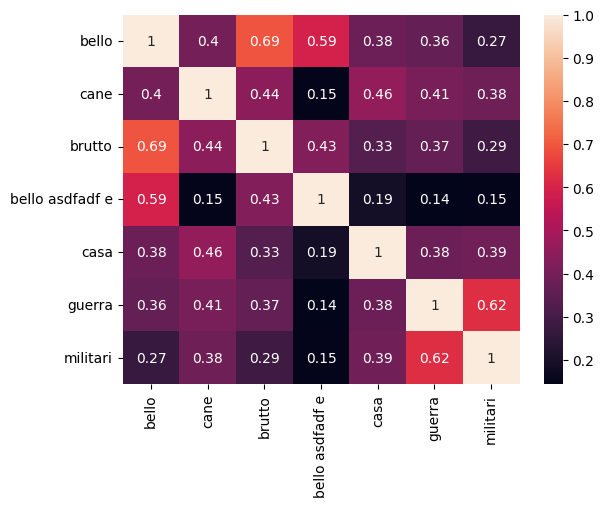

In [14]:
# test similarity matrix
texts= ['bello', 'cane', 'brutto', 'bello asdfadf e', 'casa' , 'guerra', 'militari']
matrix = similarity_matrix(texts)

# plot with labels
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(matrix, annot=True, xticklabels=texts, yticklabels=texts)

<Axes: >

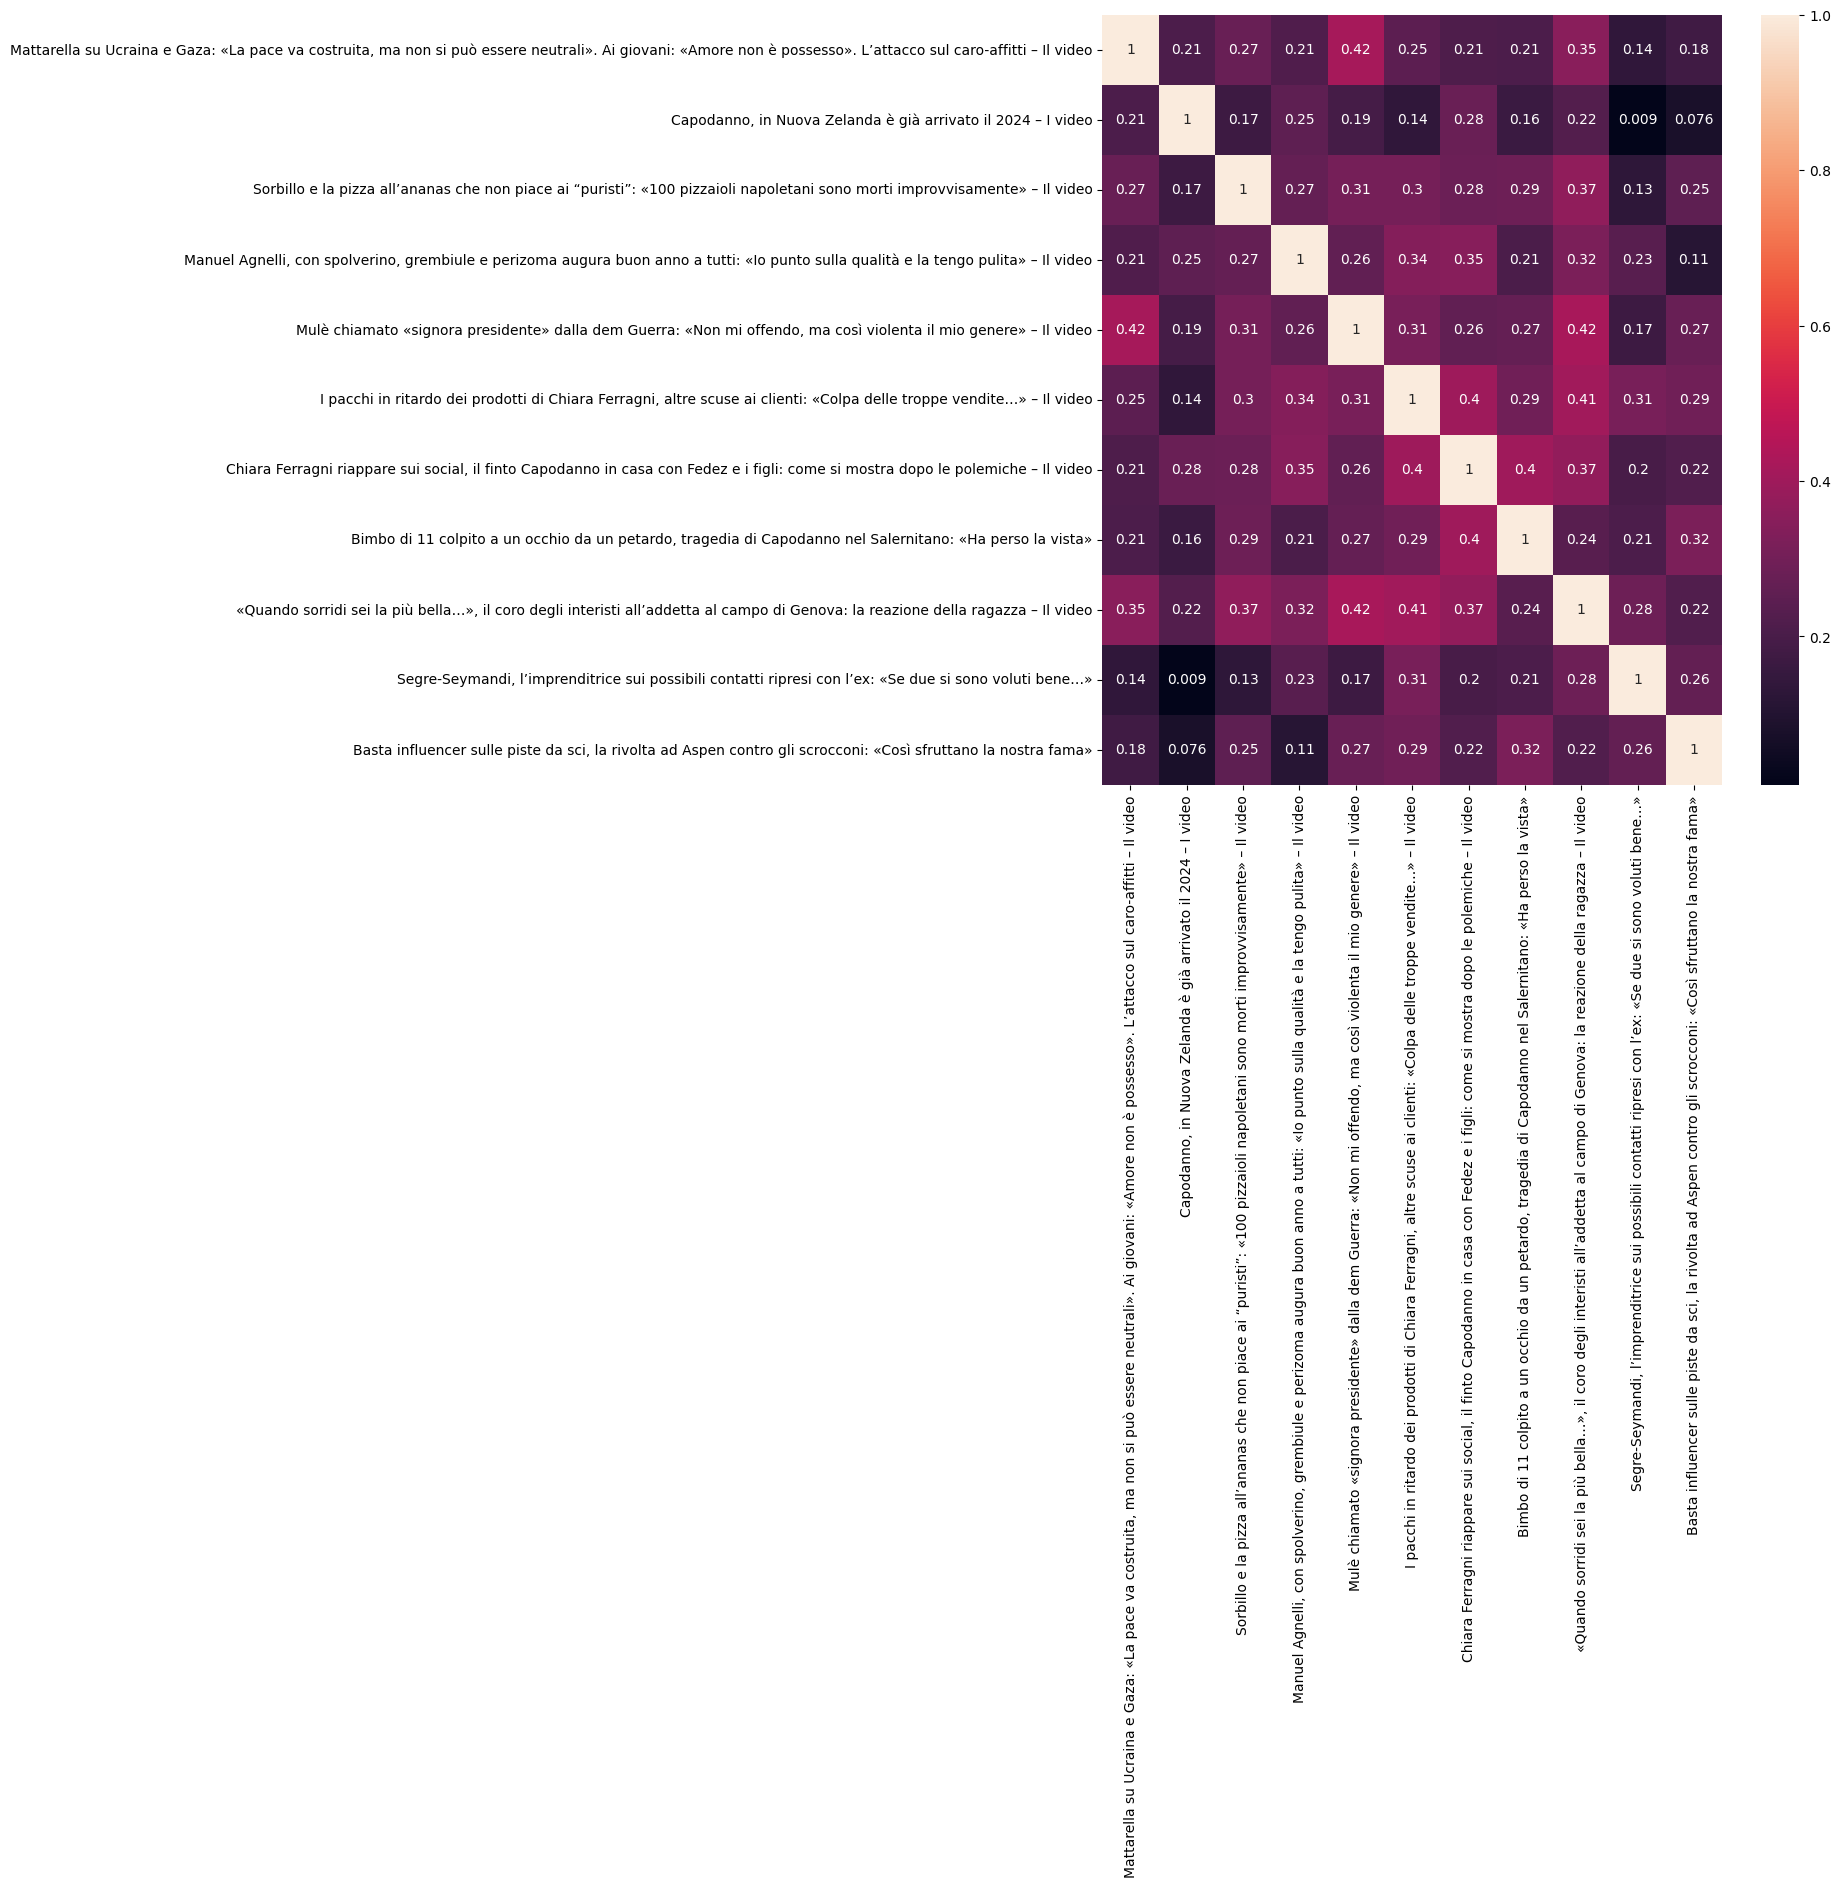

In [15]:
# Compute the similarity matrix for the titles of the articles
titles = df_day['title'].values.tolist()
similarity_matrix_titles = similarity_matrix(titles)

# Plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix_titles, annot=True, xticklabels=titles, yticklabels=titles)

<Axes: >

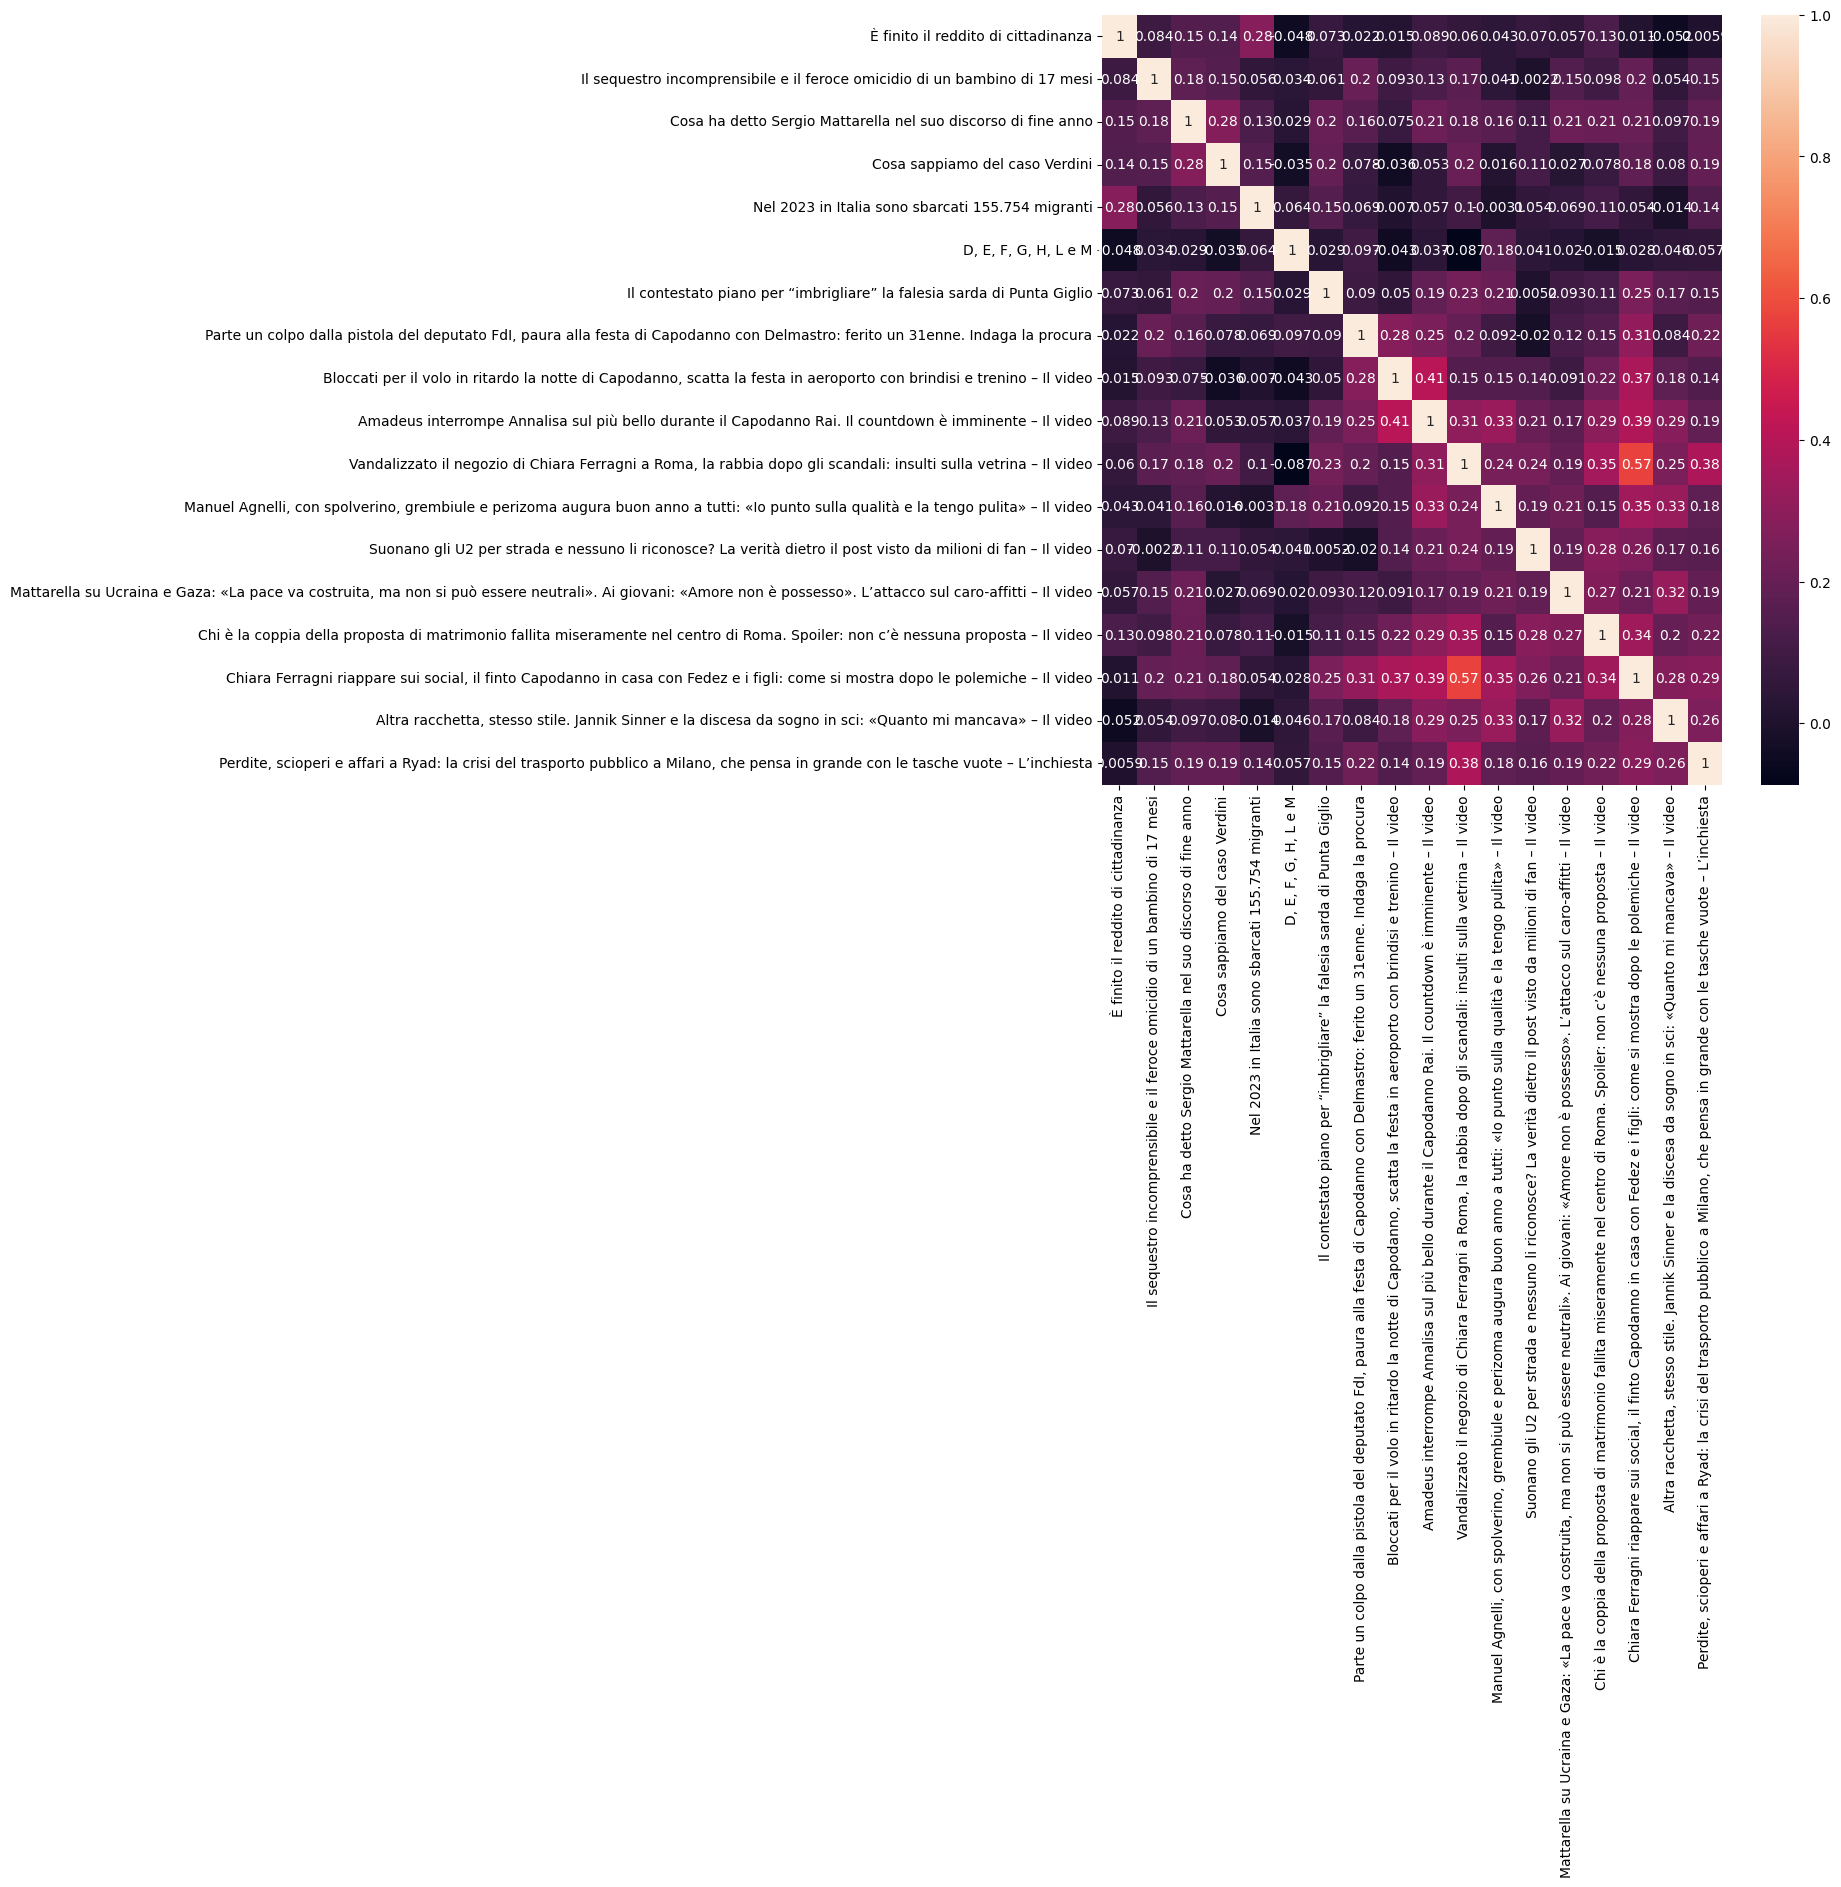

In [16]:
# test with multi source titeles
titles = ['È finito il reddito di cittadinanza',
 'Il sequestro incomprensibile e il feroce omicidio di un bambino di 17 mesi',
 'Cosa ha detto Sergio Mattarella nel suo discorso di fine anno',
 'Cosa sappiamo del caso Verdini',
 'Nel 2023 in Italia sono sbarcati 155.754 migranti',
 'D, E, F, G, H, L e M',
 'Il contestato piano per “imbrigliare” la falesia sarda di Punta Giglio',
 'Parte un colpo dalla pistola del deputato FdI, paura alla festa di Capodanno con Delmastro: ferito un 31enne. Indaga la procura',
 'Bloccati per il volo in ritardo la notte di Capodanno, scatta la festa in aeroporto con brindisi e trenino – Il video',
 'Amadeus interrompe Annalisa sul più bello durante il Capodanno Rai. Il countdown è imminente – Il video',
 'Vandalizzato il negozio di Chiara Ferragni a Roma, la rabbia dopo gli scandali: insulti sulla vetrina – Il video',
 'Manuel Agnelli, con spolverino, grembiule e perizoma augura buon anno a tutti: «Io punto sulla qualità e la tengo pulita» – Il video',
 'Suonano gli U2 per strada e nessuno li riconosce? La verità dietro il post visto da milioni di fan – Il video',
 'Mattarella su Ucraina e Gaza: «La pace va costruita, ma non si può essere neutrali». Ai giovani: «Amore non è possesso». L’attacco sul caro-affitti – Il video',
 'Chi è la coppia della proposta di matrimonio fallita miseramente nel centro di Roma. Spoiler: non c’è nessuna proposta – Il video',
 'Chiara Ferragni riappare sui social, il finto Capodanno in casa con Fedez e i figli: come si mostra dopo le polemiche – Il video',
 'Altra racchetta, stesso stile. Jannik Sinner e la discesa da sogno in sci: «Quanto mi mancava» – Il video',
 'Perdite, scioperi e affari a Ryad: la crisi del trasporto pubblico a Milano, che pensa in grande con le tasche vuote – L’inchiesta']

similarity_matrix_titles = similarity_matrix(titles)

# Plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix_titles, annot=True, xticklabels=titles, yticklabels=titles)

In [29]:
# Get the clusters of similar titles
clusters = get_clusters(titles)

# Print the clusters
for cluster_id, cluster in clusters.items():
    print(f"Cluster {cluster_id}:")
    for i in cluster:
        print(f"  - {titles[i]}")

Cluster 0:
  - Nel 2023 in Italia sono sbarcati 155.754 migranti
Cluster 2:
  - Amadeus interrompe Annalisa sul più bello durante il Capodanno Rai. Il countdown è imminente – Il video
  - Cosa sappiamo del caso Verdini
  - Mattarella su Ucraina e Gaza: «La pace va costruita, ma non si può essere neutrali». Ai giovani: «Amore non è possesso». L’attacco sul caro-affitti – Il video
  - Chi è la coppia della proposta di matrimonio fallita miseramente nel centro di Roma. Spoiler: non c’è nessuna proposta – Il video
Cluster 6:
  - Vandalizzato il negozio di Chiara Ferragni a Roma, la rabbia dopo gli scandali: insulti sulla vetrina – Il video
  - Chiara Ferragni riappare sui social, il finto Capodanno in casa con Fedez e i figli: come si mostra dopo le polemiche – Il video
Cluster 7:
  - Bloccati per il volo in ritardo la notte di Capodanno, scatta la festa in aeroporto con brindisi e trenino – Il video
  - Amadeus interrompe Annalisa sul più bello durante il Capodanno Rai. Il countdown è imm